# Environment

In [1]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

# Downloading MNIST

In [2]:
import utils
from tensorflow.contrib.learn.python.learn.datasets import mnist
import tensorflow as tf


data_sets = mnist.read_data_sets('data', dtype=tf.uint8, reshape=False, validation_size=5000)

utils.convert_to(data_sets.train, 'train', 'data')
utils.convert_to(data_sets.validation, 'validation', 'data')
utils.convert_to(data_sets.test, 'test', 'data')


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Writing data/train.tfrecords

Writing data/validation.tfrecord

# Upload dataset

In [8]:
inputs = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-mnist')

# Training script

In [9]:
!cat 'mnist.py'

import os
import tensorflow as tf
import argparse
from tensorflow.python.estimator.model_fn import ModeKeys as Modes
import numpy as np
import json

INPUT_TENSOR_NAME = 'inputs'
SIGNATURE_NAME = 'predictions'

LEARNING_RATE = 0.001


def model_fn(features, labels, mode, params):
    # Input Layer
    input_layer = tf.reshape(features[INPUT_TENSOR_NAME], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(p

# Creating job

In [13]:
from sagemaker.tensorflow import TensorFlow

mnist_estimator = TensorFlow(entry_point='mnist.py',
                             role=role,
                             framework_version='1.15.3',
                             py_version='py3',
                             training_steps=1000, 
                             evaluation_steps=100,
                             instance_count=2,
                             instance_type='ml.c4.xlarge')
#instance_type='ml.c4.xlarge'

mnist_estimator.fit(inputs)

2021-04-24 14:40:46 Starting - Starting the training job...
2021-04-24 14:40:48 Starting - Launching requested ML instancesProfilerReport-1619275246: InProgress
......
2021-04-24 14:42:01 Starting - Preparing the instances for training......
2021-04-24 14:43:12 Downloading - Downloading input data...
2021-04-24 14:43:42 Training - Training image download completed. Training in progress..WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2021-04-24 14:43:46,266 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-04-24 14:43:46,272 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-04-24 14:43:46,708 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-04-24 14:43:46,723 sagemaker-training-toolkit INFO     No GPUs detected (normal 

# Deploying model

In [193]:
mnist_predictor = mnist_estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')
#    serializer=CSVSerializer(),
#    deserializer=JSONDeserializer()

#instance_type='ml.m4.xlarge'

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------------!

In [196]:
print(mnist_predictor.endpoint_name)

tensorflow-training-2021-04-26-09-30-19-438


# Invoke endpoint

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


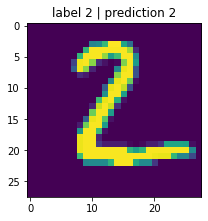

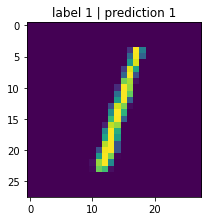

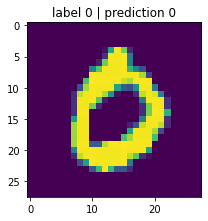

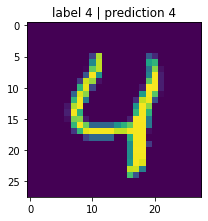

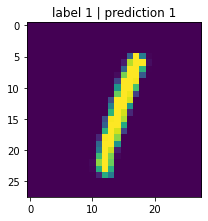

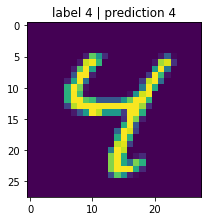

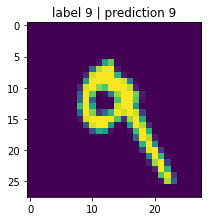

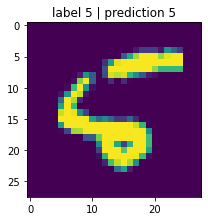

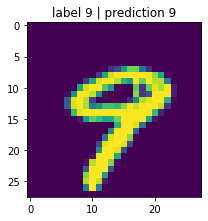

In [217]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

for i in range(1,10):
    data = mnist.test.images[i]
    predict_response = mnist_predictor.predict(data)

#    data = mnist.test.images[i].tolist()
#    predict_response = mnist_predictor.predict({"instances": np.asarray(data).tolist()})
    
    label = np.argmax(mnist.test.labels[i])
    label_text = "label {}".format(label)
    prediction = np.argmax(predict_response['predictions'])
    prediction_text = "prediction {}".format(prediction)
    final_text = label_text+" | "+prediction_text
    
    img = mnist.test.images[i].reshape(28,28)
    fig=plt.figure(figsize=(28, 28))
    fig.add_subplot(10, 1, i)
    fig.tight_layout()
    plt.title(final_text)
    plt.imshow(img)

plt.show()

# Testing data for Lambda + POST
### Predict random image from MNIST test dataset

Index in MNIST:  8503
Prediction:  9
Label:  9


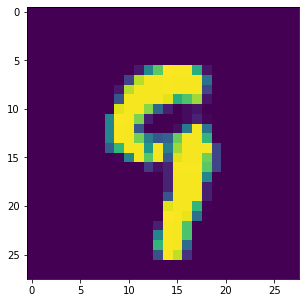

In [303]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

index = int(np.random.rand() * (len(mnist.test.images)-1))

img = mnist.test.images[index].reshape(28,28)
fig=plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(img)
    
result = mnist_predictor.predict(mnist.test.images[index])
#print(result)

print("Index in MNIST: ",index)
print("Prediction: ",np.argmax(result['predictions']))
print("Label: ", np.argmax(mnist.test.labels[index]))

# Display image's data 

In [304]:
print(mnist.test.images[index].tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666667014360428, 0.46274513006210327, 0.7490196228027344, 1.0, 0.9921569228172302, 0.992156922817230

In [292]:
import json
from json import JSONEncoder
import numpy

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
numpyArrayOne = mnist.test.images

# Serialization
numpyData = {"array": numpyArrayOne}
encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)  # use dump() to write array into file
print("Printing JSON serialized NumPy array")

# Deserialization
decodedArrays = json.loads(encodedNumpyData)
finalNumpyArray = numpy.asarray(decodedArrays["array"])
print("Decode JSON serialized NumPy array")

Printing JSON serialized NumPy array
Decode JSON serialized NumPy array


In [295]:
with open('data.json', 'w') as outfile:
    outfile.write(NumpyArrayEncoder().encode(numpyData))

In [307]:
import os
import io
import boto3
import json
import csv

i = index

key = 'data.json'
bucket = 'mnisthosting'
s3_resource = boto3.resource('s3')
s3_object = s3_resource.Object(bucket, key)
data = s3_object.get()['Body'].read().decode('utf-8')

decodedArrays = json.loads(encodedNumpyData)
finalNumpyArray = numpy.asarray(decodedArrays["array"])
print("Decode JSON serialized NumPy array")

result = mnist_predictor.predict(finalNumpyArray[i])
print((np.argmax(result['predictions'])))

Decode JSON serialized NumPy array
9


# Deleting the endpoint

In [205]:
#sagemaker.Session().delete_endpoint(mnist_predictor.endpoint)

# Using Neo (Optional)

## Compile model

In [107]:
output_path = '/'.join(mnist_estimator.output_path.split('/')[:-1])
optimized_estimator = mnist_estimator.compile_model(target_instance_family='ml_c5', 
                              input_shape={'data':[1, 784]},  # Batch size 1, 3 channels, 224x224 Images.
                              output_path=output_path,
                              framework='tensorflow', framework_version='1.15.3')

?................................!

# Image Uri

In [108]:
optimized_estimator.image_uri='746233611703.dkr.ecr.eu-central-1.amazonaws.com/sagemaker-inference-tensorflow:1.15.3-cpu-py3'

# Deploying model

In [109]:
optimized_predictor = optimized_estimator.deploy(initial_instance_count = 1,
                                   instance_type = 'ml.t2.medium')
#instance_type = 'ml.c5.xlarge'

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----------------!

In [110]:
print(optimized_predictor.endpoint_name)

tensorflow-training-ml-t2-2021-04-25-15-59-53-189


# Invoke endpoint

In [111]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

for i in range(1,10):
    data = mnist.test.images[i].tolist()
    predict_response = optimized_predictor.predict({"instances": np.asarray(data).tolist()})
    
    label = np.argmax(mnist.test.labels[i])
    label_text = "label {}".format(label)
    prediction = np.argmax(predict_response['predictions'])
    prediction_text = "prediction {}".format(prediction)
    final_text = label_text+" | "+prediction_text
    
    img = mnist.test.images[i].reshape(28,28)
    fig=plt.figure(figsize=(28, 28))
    fig.add_subplot(10, 1, i)
    fig.tight_layout()
    plt.title(final_text)
    plt.imshow(img)

plt.show()

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (502) from model with message "<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>nginx/1.18.0</center>
</body>
</html>
". See https://eu-central-1.console.aws.amazon.com/cloudwatch/home?region=eu-central-1#logEventViewer:group=/aws/sagemaker/Endpoints/tensorflow-training-ml-t2-2021-04-25-15-59-53-189 in account 687167473152 for more information.

# Delete endpoint

In [206]:
#sagemaker.Session().delete_endpoint(optimized_predictor.endpoint)

In [ ]:
#from sagemaker.serializers import CSVSerializer
#from sagemaker.deserializers import JSONDeserializer

#mnist_predictor.serializer = CSVSerializer(content_type='text/csv')
#mnist_predictor.deserializer = JSONDeserializer()

#mnist_predictor.serializer = None
#mnist_predictor.deserializer = None

#from sagemaker.predictor import csv_serializer, json_deserializer
#mnist_predictor.content_type = 'text/csv'
#mnist_predictor.serializer = csv_serializer
#mnist_predictor.deserializer = json_deserializer